# Overview

In [1]:
import pandas as pd
import numpy as np
import datetime
from ggplot import *
import altair as alt
from altair.expr import datum
alt.renderers.enable('notebook')

/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


RendererRegistry.enable('notebook')

In [2]:
visites = pd.read_csv("bu-lyon-clean-total.csv", parse_dates=[0], dayfirst=True, index_col=None, sep=";")
visites['institution'] = visites['institution'].str.replace("maker's",'makers')
visites['institution'] = visites['institution'].str.replace("makers'",'makers')

visites.head()

date  year  month  week  day institution  entrees  sorties  visiteurs  \
0 2018-09-01  2018      9    35    1     BU Bron        0        0     0.0000   
1 2018-09-02  2018      9    35    2     BU Bron        0        0     0.0000   
2 2018-09-03  2018      9    36    3     BU Bron      172      172     7.6111   
3 2018-09-04  2018      9    36    4     BU Bron      197      197    10.5000   
4 2018-09-05  2018      9    36    5     BU Bron      193      193    12.2222   

   sumentrees  sumsorties  sumvisiteurs  Totalentrees  
0           0           0        0.0000        215213  
1           0           0        0.0000        215213  
2         172         172        7.6111        215213  
3         369         369       18.1111        215213  
4         562         562       30.3333        215213

Plot the overall visits from september until now

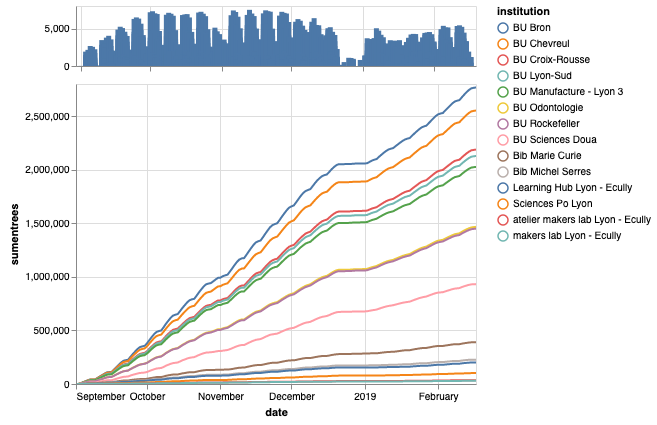

In [3]:
base = alt.Chart(visites)

#area = base.mark_area().encode(
#    x="date",
#    y="sumentrees",
#    color="institution"
#)
lines = base.mark_line().encode(
    x='date',
    y=alt.Y('sumentrees', stack='zero'),
    color=alt.Color('institution'),
)

top_hist = base.mark_bar().encode(
    x=alt.X("date", axis=alt.Axis(title='',labels=False)),
    y=alt.Y('entrees', axis=alt.Axis(title=''))
).properties(height=60)


top_hist & lines

### Sort institutions from largest to smallest number of visits

In [4]:
#alt.Chart(visites).mark_area().encode(
#    x="date",
#    y="sumentrees",
#    color="institution",
#    #order= {"aggregate": "min", "field": "Totalentrees", "type": "quantitative"}
#    order=alt.Order('Totalentrees', sort='descending')
#)


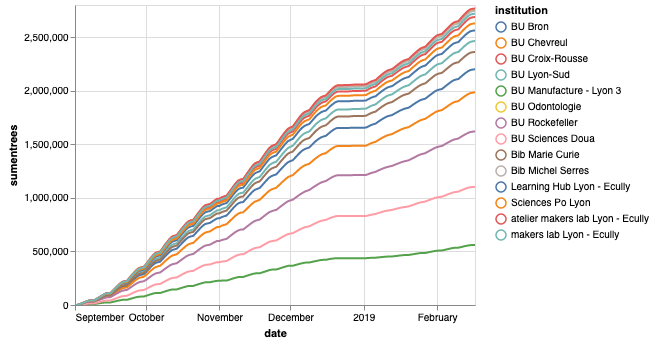

In [5]:
alt.Chart(visites).mark_line().encode(
    x='date',
    y=alt.Y('sumentrees', stack='zero'),
    color=alt.Color('institution'),
    #order= {"aggregate": "sum", "field": "Totalentrees", "type": "quantitative"}
    order=alt.Order('Totalentrees', sort='descending')
)

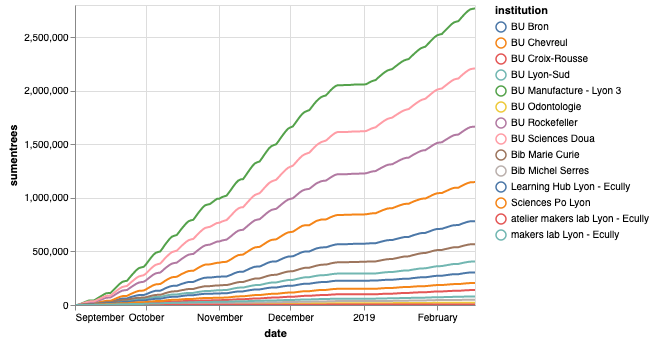

In [8]:
alt.Chart(visites).mark_line().encode(
    x='date',
    y=alt.Y('sumentrees', stack='zero'),
    color=alt.Color('institution'),
    #order= {"aggregate": "sum", "field": "Totalentrees", "type": "quantitative"}
    order=alt.Order('Totalentrees', sort='ascending')
)

### Let's now compare the evolution of all libraries

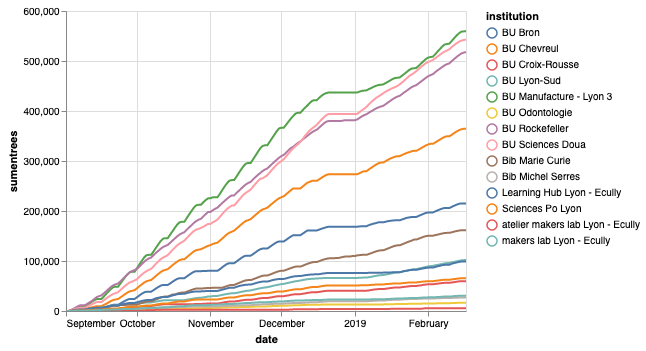

In [9]:
alt.Chart(visites).mark_line().encode(
    x='date',
    y=alt.Y('sumentrees'),
    color=alt.Color('institution'),
)

#### what i'd like:

1. [Change scales](https://altair-viz.github.io/gallery/axes_scales.html), for some reason it doesn't work.
2. Do something with the plateau around Christmas (annotate / hightlight / split)
3. Highlight the time-spans with plateau, most likely sundays, but also holydays.
  - Alternatively add an histogram on top of the chart counting the amount of "entrees"!=0 per day 

### There is a pause around Christmas, I split by year to see if the evolution changes between 2018 and 2019

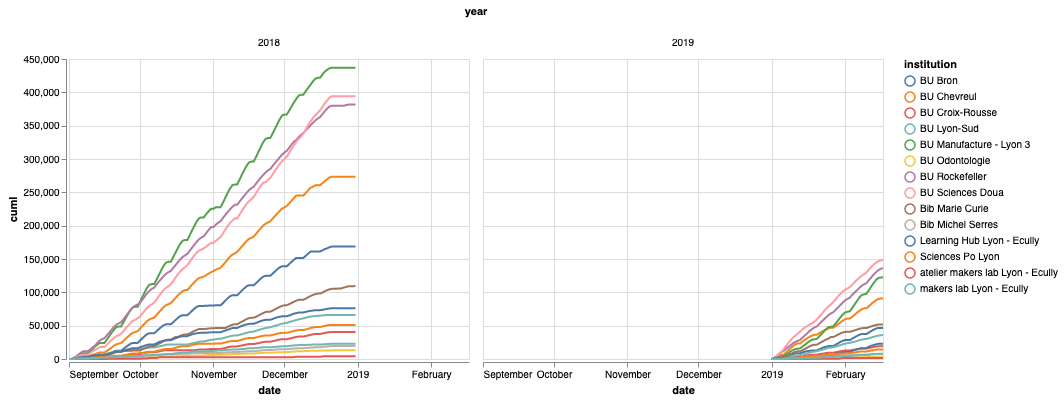

In [10]:
import altair as alt
from vega_datasets import data

base = alt.Chart(visites).mark_line().encode(
    column="year",
    x="date:T",
    #column="institution",
    y="cuml:Q",
    color="institution",
).transform_window(
    cuml='sum(entrees)',
    groupby=['institution','year'],
    frame=[None, 0]
)

#chart = alt.hconcat()
#for institution in institutions:
#    chart |= base.transform_filter(datum.institution == institution)
#chart
base

#### what i'd like:
*to cleanup and realign 2018 and 2019 to better compare the evolution of the 4 most popular libraries between their start in september and their resumption in january*

### There is a weekly pattern, I split by week

In [11]:
#institutions = np.array(list(visites.institution.drop_duplicates()))
#institutions

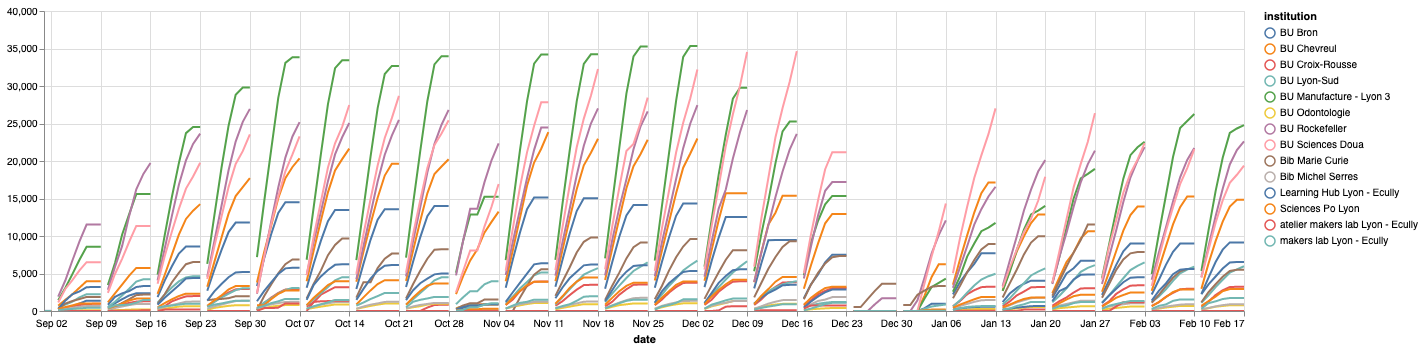

In [12]:
import altair as alt
from vega_datasets import data


def make_chart(data, week, showLabel):
    chart = alt.Chart(data).mark_line().encode(
        #column="week",
        x=alt.X("date:T"), # alt.Axis(title=week)
        #column="institution",
        y=alt.Y("cuml:Q",
                axis=alt.Axis(title='', labels=showLabel),
                scale=alt.Scale(domain=(0, 40000))
                ),
        color="institution",
    ).transform_window(
        cuml='sum(entrees)',
        groupby=['institution','week'],
        frame=[None, 0]
#    ).transform_filter(
#        (datum.Totalentrees > 300000)
    ).properties(
        width=1200, height=300
    )
    return chart

chart = alt.hconcat()
for week in visites.week.unique():
    if week==35:
        chart = make_chart(visites.loc[visites['week'] == week], str(week), True)
    else:
        chart += make_chart(visites.loc[visites['week'] == week], str(week), False)
chart


### What are the weeks with most visits ?

-> There is a peak from the beginning of october until the beginning of december. With a drop around the 1st of November (holyday).

-> BU de la Doua starts slower but lasts later.

-> BU Manufacture is the most popular, with Rokfeller, Doua and Chevreul (Lyon2), following.


### Let's look at the different types of libraries separately:

1. Split in two groups 


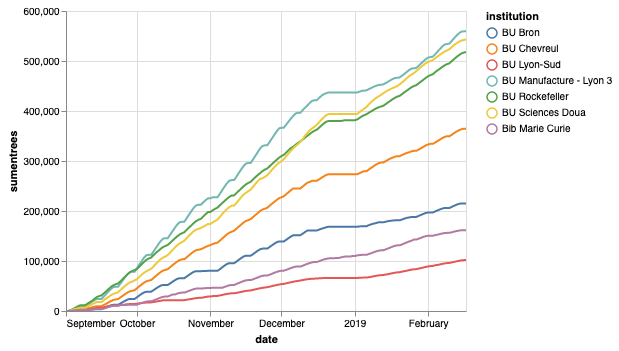

In [13]:
threshold = 100000

tophalf = alt.Chart(visites).mark_line().encode(
    x='date',
    y=alt.Y('sumentrees:Q'),
    color=alt.Color('institution'),
).transform_filter(
    (datum.Totalentrees > threshold)
)

tophalf

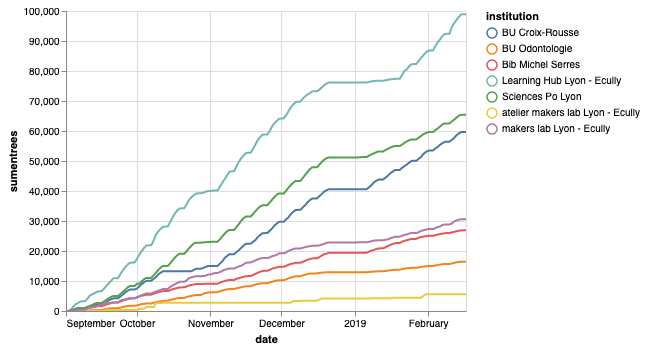

In [14]:
bottomhalf = alt.Chart(visites).mark_line().encode(
    x='date',
    y=alt.Y('sumentrees:Q'),
    color=alt.Color('institution'),
).transform_filter(
    (datum.Totalentrees < threshold)
)
bottomhalf

#### What i'd like
Actually something more dynamic to split into more groups.
- 1 group > 300000, 
- 1 group <300000 & >98000
- 1 group <70000 & >50000
- 1 group <32000

### what are the libraries changing most from week to week ?

#### TODO
one small multiple per library, with the evolution per week 

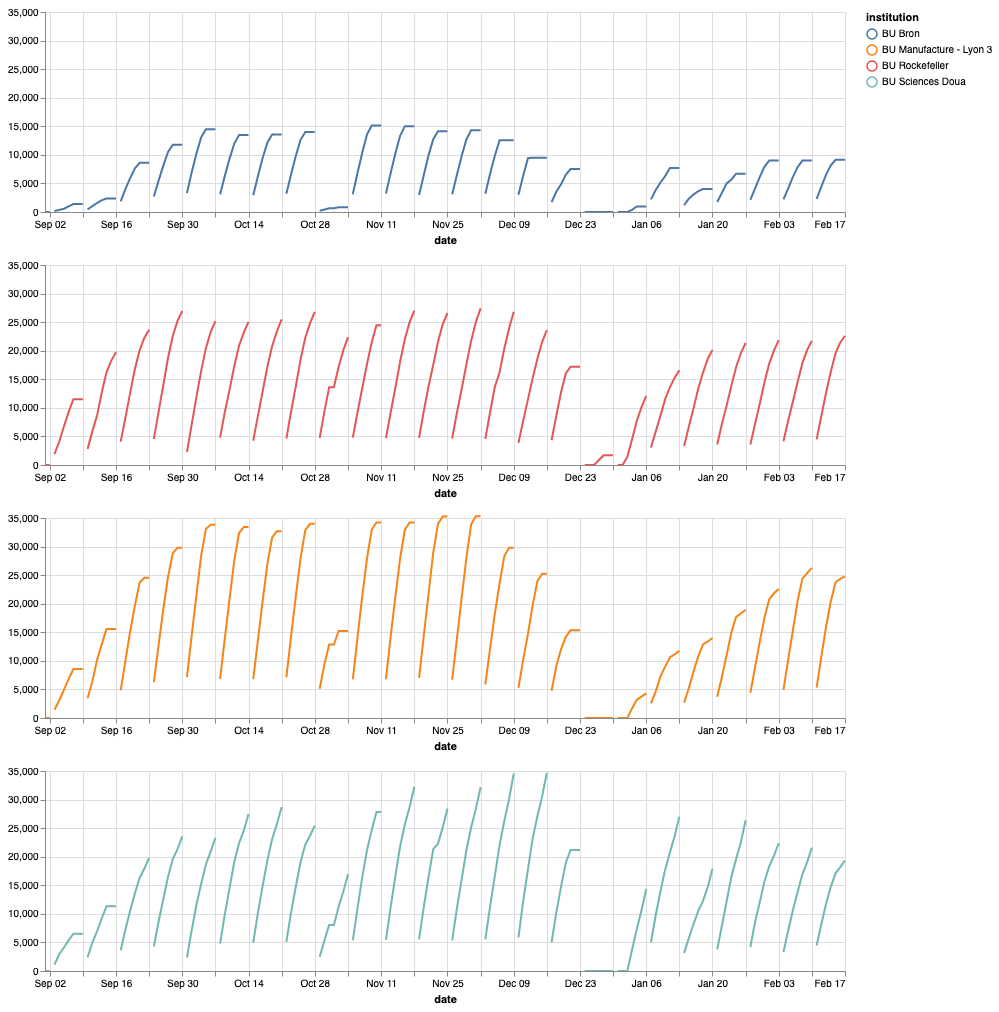

In [19]:
import altair as alt
from vega_datasets import data


def make_chart(data, week, showLabel, library):
    chart = alt.Chart(data).mark_line().encode(
        #column="week",
        x=alt.X("date:T"), # alt.Axis(title=week)
        #column="institution",
        y=alt.Y("cuml:Q",
                axis=alt.Axis(title='', labels=showLabel),
                scale=alt.Scale(domain=(0, 35000))
                ),
        color="institution",
    ).transform_filter(
        alt.FieldEqualPredicate(field='institution', equal=library)
    ).transform_window(
        cuml='sum(entrees)',
        groupby=['institution','week'],
        frame=[None, 0]
    ).properties(
        width=800, height=200
    )
    return chart

i=0
for library in ["BU Bron", "BU Rockefeller", "BU Manufacture - Lyon 3","BU Sciences Doua"]:
    for week in visites.week.unique():
        if week==35:
            chart = make_chart(visites[(visites['week'] == week)], str(week), True, library)
        else:
            chart += make_chart(visites[(visites['week'] == week)], str(week), False, library)
    charttemp = chart
    if (i==0):
        charttotal = charttemp
    else:
        charttotal &= charttemp
    i+=1
charttotal

#### Ideally the spatialisation would be more condensed,